Import the libraries we need for today's lab.  We'll be using the OpenCV in the pip repository (see lab slides on how to install).  We won't be covering NumPy today, but we're going to use it just to do some simple operations.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import errno, os
%matplotlib inline 

Commands that you see with % are for jupyter, so don't include them in your code.  This line above with run show matplotlib plots in our notebook instead of opening a window.  So let's check that our OpenCV module cv2 loaded currectly. (NOTE: I'm running the pre-release code so my version is different).

In [2]:
print("Version of opencv = ", cv2.__version__)

Version of opencv =  3.4.0-dev


So let's load an image useing cv2.imread.  There are two ways to view images: cv2.imshow() or using the matplotlib module.  matplotlib is easier when you have alot of images you want to compare at once but has some annoying properties if you are displaying images from a for-loop.  

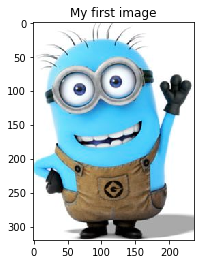

In [3]:
#TODO: use imread instead
def read_image(image_filename, gray=False):
    flag = cv2.IMREAD_GRAYSCALE if gray else cv2.IMREAD_COLOR
    image = cv2.imread(image_filename, flag)

    #if the image file does not exist, it returns none
    #So we are going to raise an error if that happens
    if image is None:
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filename)

    return image

def plot_image(img, title, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    
image = read_image("minion.jpg")
plot_image(image, "My first image")

Why does this look so funky?  This is because OpenCV opens images in <b>BGR</b> (Blue-Green-Red) channel ordering and Matplotlib (and other libraries!) assume the image is in RGB. So we need to reorder the channels.  There are two ways you can do this: use the built-in colorspace conversions (more on this later) or just use matrix indexing magic.

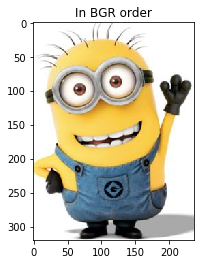

In [4]:
image = image[:,:,::-1]
plot_image(image, "In BGR order")

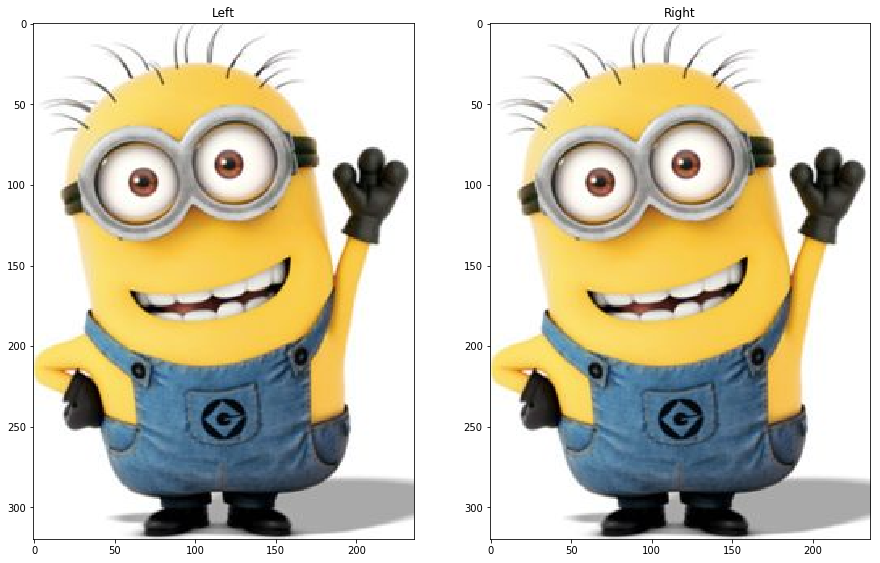

In [5]:
def plot_two_images(image_A, title_A, image_B, title_B, figsize=(15, 15)):
    """Plots two images side by side"""
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plot_image(image_A, title_A)

    plt.subplot(1, 2, 2)
    plot_image(image_B, title_B)

plot_two_images(image, "Left", image, "Right")

So now let's do some stuff to the image on the right.  Your first instinct will be to copy image to a variable like below.

In [6]:
left = image
right = image
cv2.circle(right, (100,100), radius=5, color=(0,255,0), thickness=3)

TypeError: Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)

Sometimes OpenCV messages are not very clear.  Basically, what's happening is that there is a conflict between the left and right variables.  The easy fix is to directly make a copy. 

In [7]:
left = image
right = image.copy()
print(left.dtype) #What kind of matrix is this? Images are unsigned integer by default!

uint8


Now let's do something to the image.  Drawing a circle, we pass it the center of the circle (x,y) and a color in BGR format.  Remember, colour need to be a touple!  And a thickeness of the line; if you set the thickness negatives, then the shape becomes filled (this is also true for cv2.rectangle). 

color =  (237, 184, 56)


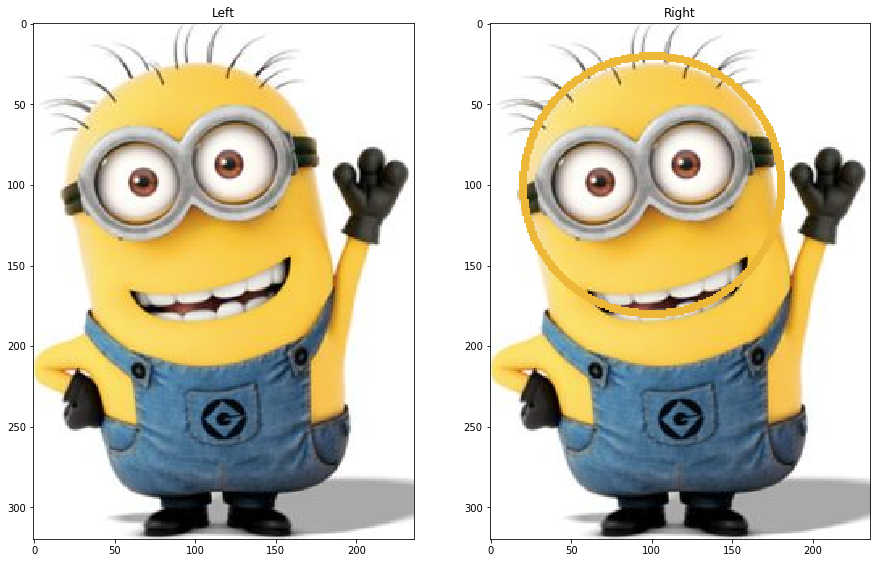

In [8]:
row = 125
col = 150

color = tuple(map(int, left[row,col])) #Convert the pixel color from uint8 to int8 and make it a tuple
print("color = ", color)

row = 100
col = 100
right = cv2.circle(right, (col,row), radius=80, color=color, thickness=3)
plot_two_images(left, "Left", right, "Right")

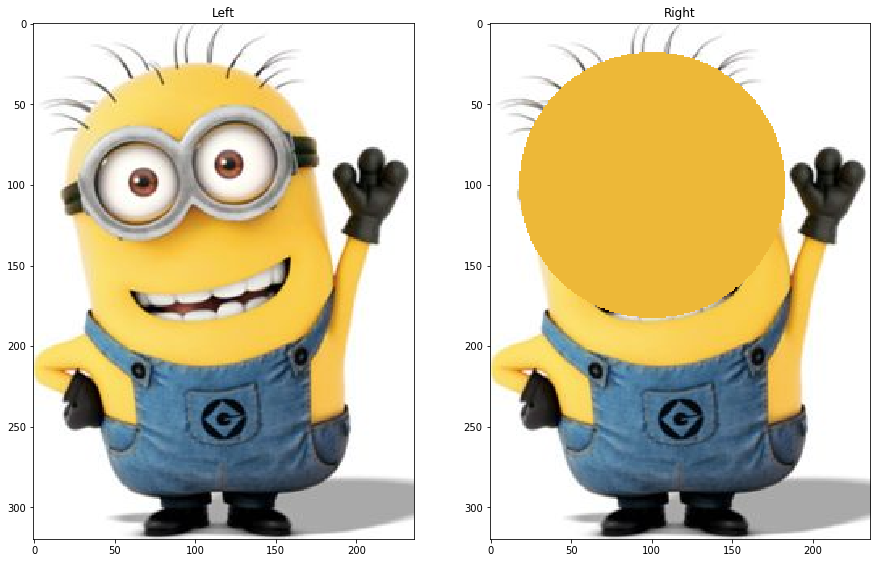

In [9]:
right = cv2.circle(right, (col,row), radius=80, color=color, thickness=-3)
plot_two_images(left, "Left", right, "Right")

So, what else can we do with raster drawing?  Well, let's take a look at a simple example where we only want part of the image!  This is called "masking".  First, we create a black and white image where the white part are the pixels we want to keep.

To draw a polygon, first you need coordinates of vertices. Make those points into an array of shape ROWSx1x2 where ROWS are number of vertices and it should be of type int32. You also want your point to be in order (clockwise or counter-clockwise).  Here we draw a small polygon of with four vertices in white color.  Because you are doing a 1-channel image, we don't need to use a tuple for the color (only a scalar).
 

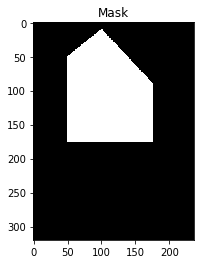

In [10]:
#Create a black image the same size of our image (but only 1 channel!)
mask = np.zeros(left.shape[:2], dtype=np.uint8) #We'll learn more NumPy later!

#Let's draw our mask using polygon
#pts = np.array([[10,100],[20,30],[70,20],[50,10]], np.int32)

pts = np.array([[100, 10],[175,90],[175,175],[50,175],[50,50]], np.int32)

#Again, we'll talk about this more when we cover NumPy but we just
#reshape the array into a shape the polylines functions understand
pts = pts.reshape((-1,1,2))

#We tell polylines to close the figure (True) and make the color white (255)
#If you don't want a closed shape, set False (this is faster than using cv2.lines())
mask = cv2.polylines(mask,[pts],True,255)

#Fill in the polygon with white (255)
mask = cv2.fillConvexPoly(mask,pts,255)

plot_image(mask, "Mask", cmap='gray')

Now let's add some text to the image so we get an interesting font styling.

To put texts in images, you need specify following things.

    Text data that you want to write
    Position coordinates of where you want put it (i.e. bottom-left corner where data starts).
    Font type (Check cv2.putText() docs for supported fonts)
    Font Scale (specifies the size of font)
    regular things like color, thickness, lineType etc. For better look, lineType = cv2.LINE_AA is recommended.

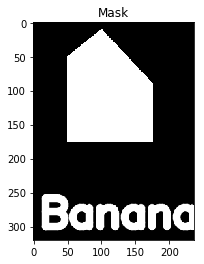

In [11]:
font = cv2.FONT_HERSHEY_SIMPLEX
#Notice that I can still use a tuple even if I'm drawing on a 1-channel image
mask = cv2.putText(mask,'Banana!',(10,300), font, 2,(255,255,255),10,cv2.LINE_AA)
plot_image(mask, "Mask", cmap='gray')

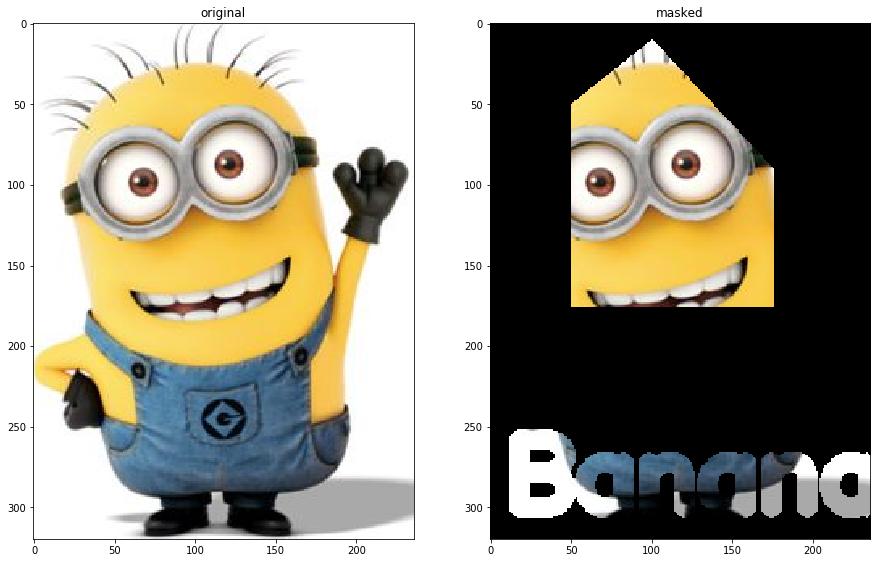

In [12]:
output = cv2.bitwise_and(left, left, mask=mask)
plot_two_images(left, "original", output, "masked")